In [1]:
import numpy as np
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import healpy as hp

def cat2hpx(ra, dec, nside):
    
    npix = hp.nside2npix(nside)

    # conver to theta, phi
    theta = np.pi/2 - dec
    phi = ra

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

def gen_skyloc(samps, nside=32, levels=[0.9, 0.5]):
    RA_post = np.array(samps['ra'])
    DEC_post = np.array(samps['dec'])
    
    npix = hp.nside2npix(nside)
    H = cat2hpx(RA_post, DEC_post, nside=nside)
    theta, phi = hp.pix2ang(nside, np.arange(npix))

    ra = phi
    dec = np.pi/2 - theta
    ra_shift = ra - np.pi

    Hflat = H.flatten()
    inds = np.argsort(Hflat)[::-1]
    Hflat = Hflat[inds]
    sm = np.cumsum(Hflat)
    sm = sm/sm[-1]

    V = np.empty(len(levels))
    for i, v0 in enumerate(levels):
        try:
            V[i] = Hflat[sm <= v0][-1]
        except:
            V[i] = Hflat[0]
            
    return ra_shift, dec, H, V

In [2]:
repodir = '.'
prior_class = 'IASPrior'
prior_class_comoving = 'IASPriorComovingVT'
prior_class_lvc = 'LVCPrior'
prior_class_lvc_comoving = 'LVCPriorComovingVT'
ias_evnames = ['GW190707_083226',
               'GW190711_030756',
               'GW190818_232544',
               'GW190704_104834',
               'GW190906_054335',
               'GW190821_124821', 
               'GW190814_192009',
               'GW190910_012619',
               'GW190920_113516',
               'GW190718_160159']

%matplotlib notebook

In [3]:
evname = 'GW190704_104834' #'GW190920_113516'
prior = prior_class_lvc_comoving
fname_samples = os.path.join(repodir, prior, evname + '_posterior_samples.feather')
samples = pd.read_feather(fname_samples)

<IPython.core.display.Javascript object>


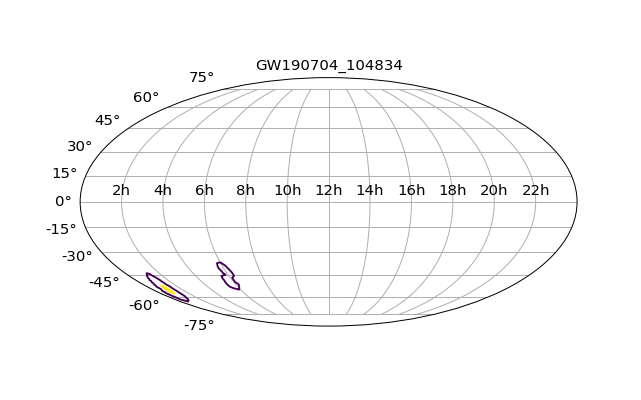

In [4]:
fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(111, projection="mollweide")

ra_sym, dec, H, V = gen_skyloc(samples)
ax.tricontour(ra_sym, dec, H, levels=V)

ax.tick_params(labelsize=12)
ax.set_xticklabels(['2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'])
plt.title(evname)
plt.grid(True)

In [5]:
max_ns_mass = 2.5
samples_ns = samples[samples['m2'] < max_ns_mass]

<IPython.core.display.Javascript object>


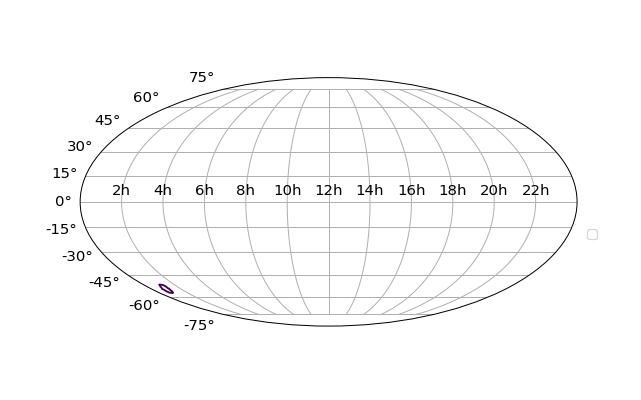

In [6]:
name_list = [evname]

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(111, projection="mollweide")

ra_sym, dec, H, V = gen_skyloc(samples_ns)
ax.tricontour(ra_sym, dec, H, levels=V)

ax.tick_params(labelsize=12)
ax.set_xticklabels(['2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'])
ax.legend(name_list, loc=[1.02, 0.35])

plt.grid(True)
fig.show()

In [7]:
max_ns_spin = .5
samples['s2'] = np.sqrt(samples['s2x']**2 +
                        samples['s2y']**2 +
                        samples['s2z']**2)
samples_ns_lospin = samples[((samples['m2'] < max_ns_mass) &
                             (samples['s2'] < max_ns_spin))]

<IPython.core.display.Javascript object>


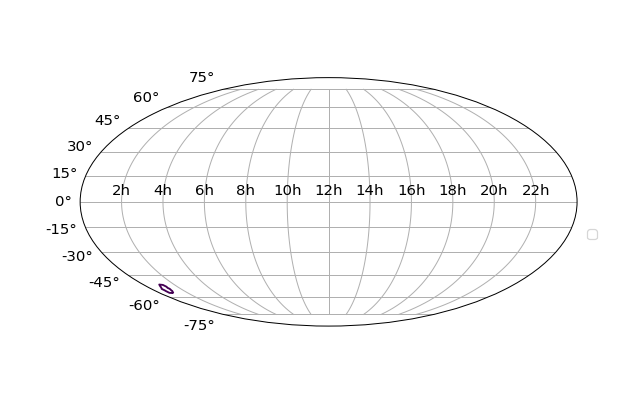

In [8]:
name_list = [evname]

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(111, projection="mollweide")

ra_sym, dec, H, V = gen_skyloc(samples_ns_lospin)
ax.tricontour(ra_sym, dec, H, levels=V)

ax.tick_params(labelsize=12)
ax.set_xticklabels(['2h', '4h', '6h', '8h', '10h', '12h', '14h', '16h', '18h', '20h', '22h'])
ax.legend(name_list, loc=[1.02, 0.35])

plt.grid(True)
fig.show()

In [9]:
fname_samples_iasprior = os.path.join(repodir, prior_class_comoving, evname + '_posterior_samples.feather')
samples_iasprior = pd.read_feather(fname_samples_iasprior)

<IPython.core.display.Javascript object>


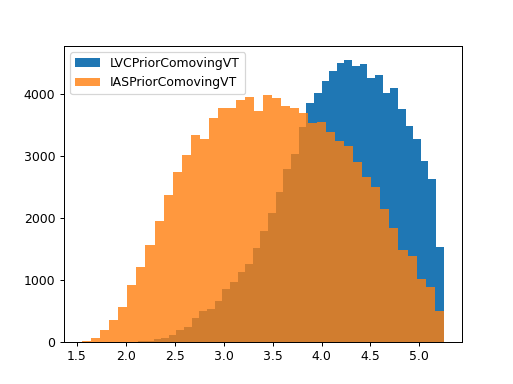

In [10]:
plt.figure()
m2_hist = plt.hist(samples['m2'], bins=40, label=prior)
m2_hist_iasprior = plt.hist(samples_iasprior['m2'], bins=40, alpha=.8, label=prior_class_comoving)
plt.legend()